In [ ]:
# 한글 안 깨지게
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
# 폰트설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] =False

In [ ]:
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')

In [ ]:
df

,DATE,GDP(십억원),GNI(십억원),GDP_GROWTH(%),KOSPI,국고채(3년)(%),국고채(10년)(%),뉴스심리지수,경제심리지수,수출금액지수,...,미국PPI,본원 통화(달러 발행량),미국 소비자심리지수,금,은,원유,한국실업률,미국실업률,중국위안/달러,장단기금리차
0,2005-01-01,311097.1,318178.7,0.9,895.92,3.280,3.810,95.60,95.7,50.28,...,150.900,775.2,95.5,437.500000,6.807000,43.450001,3.8,5.3,8.266501,0.530
1,2005-01-02,311097.1,318178.7,0.9,895.92,3.280,3.810,97.10,95.7,50.28,...,150.900,775.2,95.5,437.500000,6.807000,43.450001,3.8,5.3,8.266501,0.530
2,2005-01-03,311097.1,318178.7,0.9,893.71,3.380,3.930,101.07,95.7,50.28,...,150.900,775.2,95.5,428.700012,6.477000,42.119999,3.8,5.3,8.266501,0.550
3,2005-01-04,311097.1,318178.7,0.9,886.90,3.370,3.990,101.52,95.7,50.28,...,150.900,775.2,95.5,428.500000,6.427000,43.910000,3.8,5.3,8.266501,0.620
4,2005-01-05,311097.1,318178.7,0.9,885.19,3.340,4.000,102.00,95.7,50.28,...,150.900,775.2,95.5,426.600006,6.512000,43.389999,3.8,5.3,8.266501,0.660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,2025-02-24,572216.0,557999.9,0.1,2645.27,2.610,2.825,103.48,90.2,124.11,...,259.805,5614.0,64.7,2947.899902,32.575001,70.699997,2.7,4.1,7.250000,0.215
7360,2025-02-25,572216.0,557999.9,0.1,2630.29,2.596,2.797,101.32,90.2,124.11,...,259.805,5614.0,64.7,2904.500000,31.801001,68.930000,2.7,4.1,7.247600,0.201
7361,2025-02-26,572216.0,557999.9,0.1,2641.09,2.591,2.752,102.28,90.2,124.11,...,259.805,5614.0,64.7,2916.800049,32.252998,68.620003,2.7,4.1,7.247600,0.161
7362,2025-02-27,572216.0,557999.9,0.1,2621.75,2.592,2.754,102.51,90.2,124.11,...,259.805,5614.0,64.7,2883.199951,31.801001,70.349998,2.7,4.1,7.258000,0.162


In [ ]:
# 예측 대상과 입력 피처 정의
target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

In [ ]:
# 피처 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])

In [ ]:
# 시퀀스 생성 함수
def create_multivariate_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
target_idx = list(feature_cols).index(target_col)

X, y = create_multivariate_sequences(scaled, target_idx, seq_len)

In [ ]:
# Train/Test 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        # 계산: 점수 = tanh(XW + b)
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)  # 시점별 가중치
        output = x * a  # 가중치 곱해서 출력 생성
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)  # 커스텀 Attention layer
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from keras.callbacks import EarlyStopping
model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
model.summary()

es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[es])

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 30, 42)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 64)             │            94 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,599 (115.62 KB)

 Trainable params: 29,599 (115.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0068 - val_loss: 0.0014
Epoch 2/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 4/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 5/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9.4764e-04 - val_loss: 0.0014
Epoch 6/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 8.9797e-04 - val_loss: 0.0015
Epoch 8/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8.2077e-04 - val_loss: 0.0017
Epoch 9/30
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 8.9786e-04 - val_loss: 0.0034


<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-34-dfebffb49266>:12: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ip

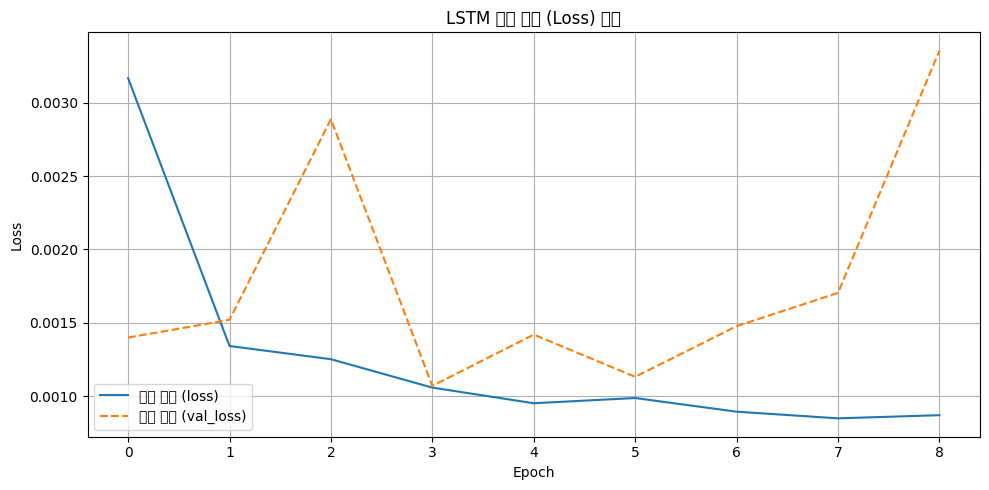

In [ ]:
# LSTM 학습 곡선 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='훈련 손실 (loss)')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='검증 손실 (val_loss)', linestyle='--')

plt.title('LSTM 학습 손실 (Loss) 변화')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 예측
y_pred = model.predict(X_test)

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
# 역정규화: 타깃 컬럼만
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

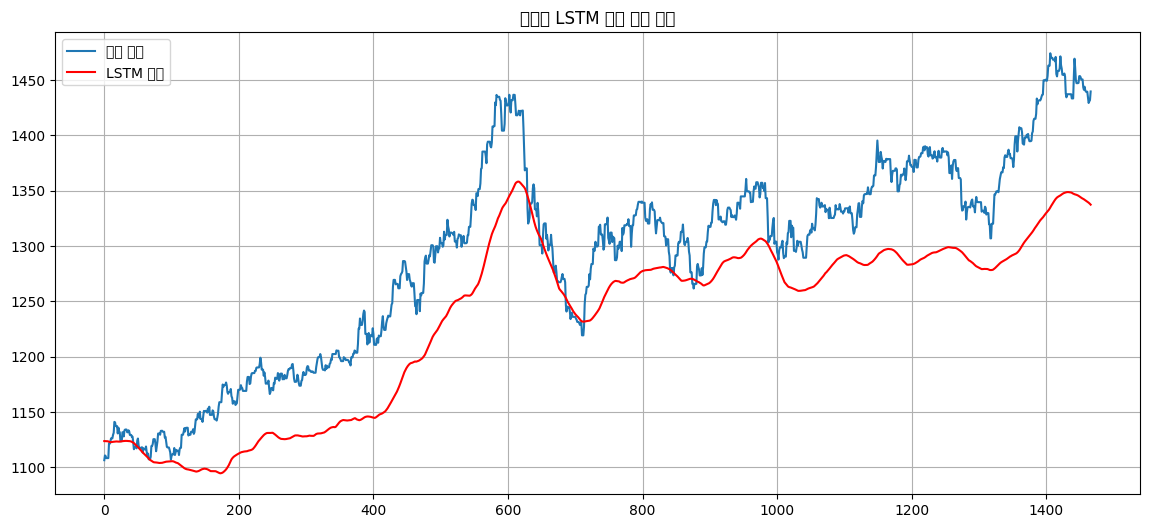

In [ ]:
# 시각화
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv, label='실제 환율')
plt.plot(y_pred_inv, label='LSTM 예측', color='red')
plt.title('다변량 LSTM 환율 예측 결과')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

mse = mean_squared_error(y_test, y_pred)
print(f'MSE : {mse}')

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE : {rmse}')

mae = mean_absolute_error(y_test, y_pred)
print(f'MAE : {mae}')

r2 = r2_score(y_test, y_pred)
print(f'R2 : {r2}')

# acc = accuracy_score(y_test, y_pred)
# print(f'Accuracy : {acc}')

MSE : 0.00875072909811253
RMSE : 0.09354533178150864
MAE : 0.08273046347279706
R2 : 0.5388560183184937


In [ ]:
n_future = 30  # 예측하고 싶은 미래 일 수
last_seq = X_test[-1]  # 마지막 입력 시퀀스 하나 선택 (shape: [seq_len, n_features])
future_preds = []

curr_seq = last_seq.copy()

for _ in range(n_future):
    # (1) 입력 shape 맞춰주기
    input_seq = curr_seq.reshape(1, seq_len, X.shape[2])

    # (2) 예측
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # (3) 예측값을 시퀀스에 붙여 넣기
    next_step = curr_seq[1:].copy()  # 기존 시퀀스에서 첫 번째 날 제거
    new_row = curr_seq[-1].copy()    # 마지막 날의 변수들 복사

    new_row[target_idx] = pred       # 우리가 예측한 값만 대체!
    curr_seq = np.vstack([next_step, new_row])  # 새로운 시퀀스 구성

In [ ]:
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 54872 (\N{HANGUL SYLLABLE HWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-41-6bd427c7fb82>:13: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython

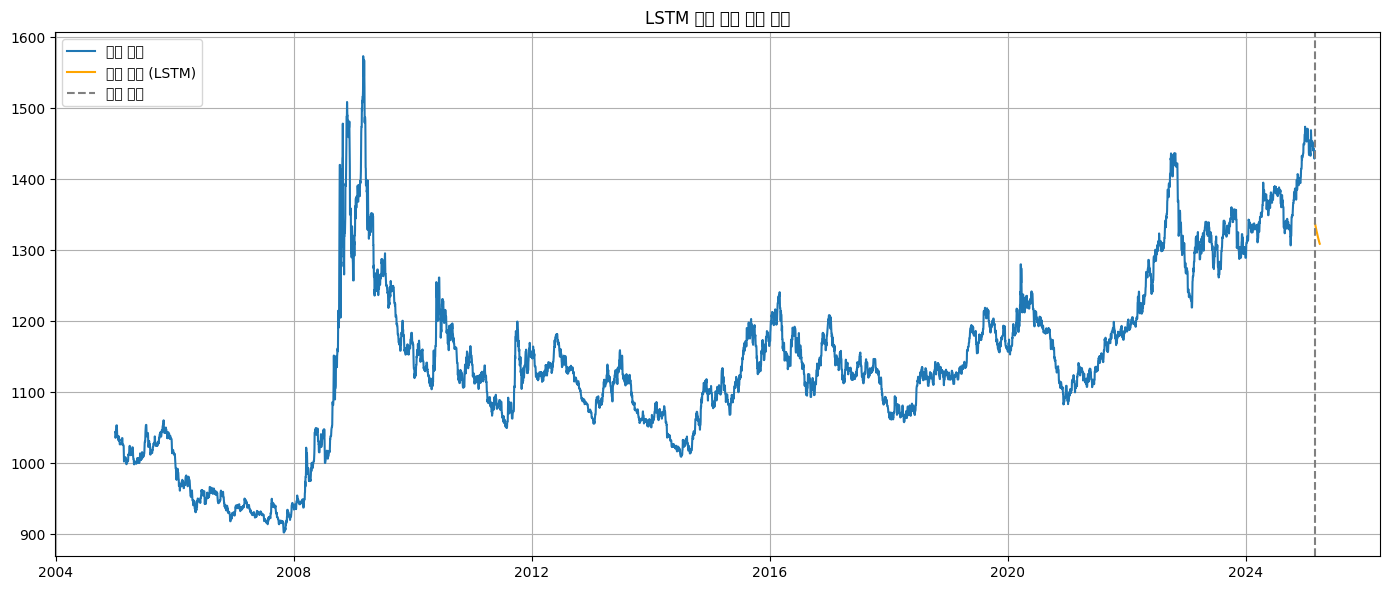

In [ ]:
# 마지막 날짜 이후부터 미래 n일 생성
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(df['DATE'], df[target_col], label='실제 환율')
plt.plot(future_dates, future_preds_inv, label='미래 예측 (LSTM)', color='orange')
plt.axvline(x=last_date, color='gray', linestyle='--', label='예측 시작')
plt.legend()
plt.title('LSTM 기반 미래 환율 예측')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
new = pd.read_csv('/content/new_0421.csv', parse_dates=['DATE'])
dollar0413 = new[new['DATE']>='2025-03-01'][['DATE','원/미국달러(매매기준율)']]
dollar0413 = dollar0413.reset_index(drop=True)

In [ ]:
real = pd.DataFrame(future_preds_inv, columns=['예측환율'])
real = pd.concat([dollar0413, real], axis=1).dropna()
real['예측차이'] = abs(real['원/미국달러(매매기준율)']-real['예측환율'])
real

,DATE,원/미국달러(매매기준율),예측환율,예측차이
0,2025-03-01,1439.6,1337.354126,102.245874
1,2025-03-02,1439.6,1336.415649,103.184351
2,2025-03-03,1439.6,1335.344482,104.255518
3,2025-03-04,1458.7,1334.145386,124.554614
4,2025-03-05,1459.6,1333.050171,126.549829
5,2025-03-06,1456.0,1331.902832,124.097168
6,2025-03-07,1441.6,1330.673218,110.926782
7,2025-03-08,1441.6,1329.418701,112.181299
8,2025-03-09,1441.6,1328.288574,113.311426
9,2025-03-10,1446.3,1327.240967,119.059033


# Rolling Forecast 시계열 교차검증

In [ ]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [ ]:
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
# 데이터 로드
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 20
X, y = create_sequences(scaled, target_idx, seq_len)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []

initial_window = int(len(X) * 0.6)
step_size = int(len(X) * 0.1)

for i, start in enumerate(range(initial_window, len(X) - step_size, step_size)):
    print(f"\n📦 Fold {i+1}")
    X_train_cv, y_train_cv = X[:start], y[:start]
    X_val_cv, y_val_cv = X[start:start + step_size], y[start:start + step_size]

    model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    y_pred_cv = model.predict(X_val_cv)

    mse = mean_squared_error(y_val_cv, y_pred_cv)
    mae = mean_absolute_error(y_val_cv, y_pred_cv)
    r2 = r2_score(y_val_cv, y_pred_cv)

    print(f"  ✅ MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)

print("\n📊 전체 평균 성능")
print(f"▶ 평균 MSE : {np.mean(mse_scores):.4f}")
print(f"▶ 평균 MAE : {np.mean(mae_scores):.4f}")
print(f"▶ 평균 R²  : {np.mean(r2_scores):.4f}")


📦 Fold 1
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
  ✅ MSE: 0.0010, MAE: 0.0272, R²: 0.3399

📦 Fold 2
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
  ✅ MSE: 0.0010, MAE: 0.0269, R²: 0.7006

📦 Fold 3
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
  ✅ MSE: 0.0013, MAE: 0.0320, R²: 0.9216

📦 Fold 4
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
  ✅ MSE: 0.0095, MAE: 0.0848, R²: -0.9884

📊 전체 평균 성능
▶ 평균 MSE : 0.0032
▶ 평균 MAE : 0.0427
▶ 평균 R²  : 0.2434


<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-49-850b08f8ae4d>:9: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/

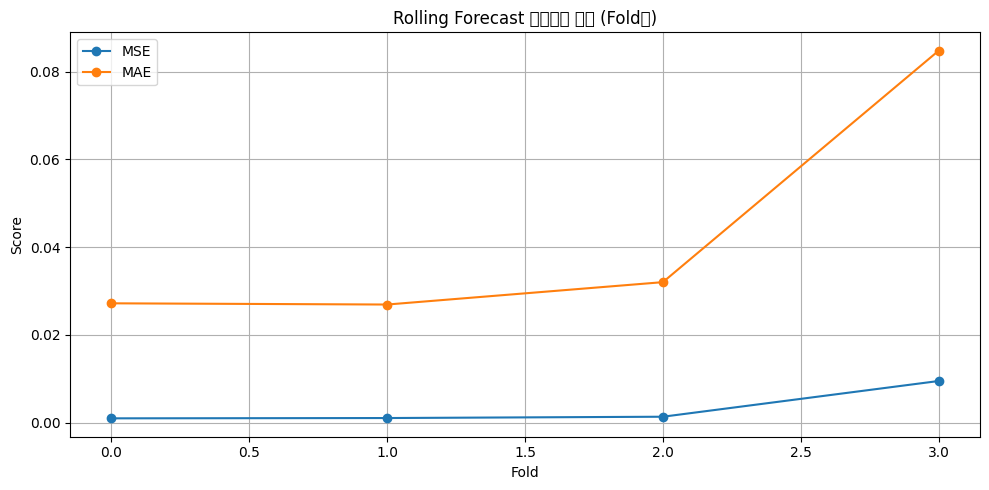

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(mse_scores, marker='o', label='MSE')
plt.plot(mae_scores, marker='o', label='MAE')
plt.title('Rolling Forecast 교차검증 성능 (Fold별)')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# ✅ 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

# ✅ 데이터 로딩
# df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')

# ✅ 타겟 및 피처 정의
target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

# ✅ 시퀀스 생성 함수
def create_multivariate_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
X, y = create_multivariate_sequences(scaled, target_idx, seq_len)

# ✅ 학습/테스트 분리
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# ✅ Attention Layer 정의
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ✅ 모델 빌드 함수
def build_lstm_attention_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

# ✅ 모델 학습
model = build_lstm_attention_model(seq_len=seq_len, n_features=X.shape[2])
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

# ✅ 미래 예측: 2025년 4월 24일까지
from datetime import datetime

future_end = pd.to_datetime("2025-04-24")
n_future = (future_end - df['DATE'].max()).days

last_seq = X_test[-1]
curr_seq = last_seq.copy()
future_preds = []

# 정규화 복원용 스케일러
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])

for _ in range(n_future):
    input_seq = curr_seq.reshape(1, seq_len, X.shape[2])
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)

    next_step = curr_seq[1:].copy()
    new_row = curr_seq[-1].copy()
    new_row[target_idx] = pred
    curr_seq = np.vstack([next_step, new_row])

future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))
future_dates = pd.date_range(start=df["DATE"].max() + pd.Timedelta(days=1), periods=n_future)
forecast_df = pd.DataFrame({"DATE": future_dates, "예측환율": future_preds_inv.flatten()})

# ✅ 예측 결과 확인
forecast_df.tail()

,DATE,예측환율
50,2025-04-20,1460.578247
51,2025-04-21,1460.583130
52,2025-04-22,1460.587891
53,2025-04-23,1460.593018
54,2025-04-24,1460.598999


In [ ]:
# ✅ Google Colab에서 실행할 수 있는 전체 코드 (tensorflow 설치 후 가정)

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from datetime import timedelta

# ✅ 데이터 로드 및 정리
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE', target_col])

df = df.sort_values('DATE').dropna()
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[feature_cols])
y_scaled = scaler_y.fit_transform(df[[target_col]])

# ✅ 시퀀스 생성 함수
def create_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# ✅ 시퀀스 생성
window_size = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, window=window_size)
X_train, X_test = X_seq[:-30], X_seq[-30:]
y_train, y_test = y_seq[:-30], y_seq[-30:]

# ✅ LSTM 모델
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ✅ LSTM 예측
lstm_pred_scaled = lstm_model.predict(X_test)
lstm_pred = scaler_y.inverse_transform(lstm_pred_scaled)

# ✅ 평탄화된 데이터 (XGB, LGBM용)
X_flat = X_scaled[window_size-1:-1]
y_flat = y_scaled[window_size:]
X_train_flat, X_test_flat = X_flat[:-30], X_flat[-30:]
y_train_flat, y_test_flat = y_flat[:-30], y_flat[-30:]

# ✅ XGBoost
xgb_model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8, random_state=42, verbosity=0)
xgb_model.fit(X_train_flat, y_train_flat.ravel())
xgb_pred = scaler_y.inverse_transform(xgb_model.predict(X_test_flat).reshape(-1, 1))

# ✅ LightGBM
lgbm_model = LGBMRegressor(n_estimators=300, max_depth=5, learning_rate=0.05, subsample=0.8, random_state=42)
lgbm_model.fit(X_train_flat, y_train_flat.ravel())
lgbm_pred = scaler_y.inverse_transform(lgbm_model.predict(X_test_flat).reshape(-1, 1))

# ✅ 앙상블 (평균)
ensemble_pred = (lstm_pred + xgb_pred + lgbm_pred) / 3

# ✅ 결과 정리
last_date = df['DATE'].iloc[-30]
dates = pd.date_range(start=last_date, periods=30, freq='D')

results = pd.DataFrame({
    'DATE': dates,
    'LSTM_예측': lstm_pred.ravel(),
    'XGBoost_예측': xgb_pred.ravel(),
    'LightGBM_예측': lgbm_pred.ravel(),
    '앙상블_예측': ensemble_pred.ravel()
})

results = results[results['DATE'].dt.dayofweek < 5]  # 평일만 필터링
results.reset_index(drop=True, inplace=True)

print(results)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7939
[LightGBM] [Info] Number of data points in the train set: 7304, number of used features: 41
[LightGBM] [Info] Start training from score 0.356456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LSTM Attention으로 3월 예측하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

# ✅ 데이터 불러오기
df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')
df = df.sort_values('DATE').dropna()

# ✅ 타겟과 피처 정의
target_col = '원/미국달러(매매기준율)'
feature_cols = df.columns.drop(['DATE'])

# ✅ 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[feature_cols])
target_idx = list(feature_cols).index(target_col)

# ✅ 시퀀스 생성 함수
def create_sequences(data, target_idx, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

# ✅ 시퀀스 설정
seq_len = 30
X, y = create_sequences(scaled, target_idx, seq_len)
X_train, y_train = X, y  # 전체 데이터를 학습에 사용

# ✅ Attention Layer 정의
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1),
                                 initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1),
                                 initializer='zeros', trainable=True)
        super(Attention, self).build(input_shape)
    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ✅ LSTM + Attention 모델 정의
def build_model(seq_len, n_features):
    inputs = Input(shape=(seq_len, n_features))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_model(seq_len, X.shape[2])
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# ✅ 3월 1일부터 30일 예측
n_future = 30
last_seq = X[-1]
future_preds = []
curr_seq = last_seq.copy()

for _ in range(n_future):
    input_seq = curr_seq.reshape(1, seq_len, X.shape[2])
    pred = model.predict(input_seq, verbose=0)[0][0]
    future_preds.append(pred)
    next_step = curr_seq[1:].copy()
    new_row = curr_seq[-1].copy()
    new_row[target_idx] = pred
    curr_seq = np.vstack([next_step, new_row])

# ✅ 역정규화
target_scaler = MinMaxScaler()
target_scaler.fit(df[[target_col]])
future_preds_inv = target_scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# ✅ 날짜 생성 및 출력
last_date = df['DATE'].max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future)
forecast_df = pd.DataFrame({'DATE': future_dates, '예측환율': future_preds_inv.flatten()})

print(forecast_df)

Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0091
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0013
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0013
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0010
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 9.7760e-04
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 8.6755e-04
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 9.0455e-04
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 8.2359e-04
Epoch 9/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.1016e-04
Epoch 10/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 7.1472e-04
Epoch 11/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 7.8016e-04
Epoch 12/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 6.6076e-04
Epoch 13/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 5.5881e-04
Epoch 14/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 6.1638e-04
Epo

1. Feature줄이는 과정

In [ ]:
# ✅ 필요한 라이브러리
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

# ✅ 데이터 불러오기 (이미 업로드한 all_features.csv)
# df = pd.read_csv('/content/all_features.csv', parse_dates=['DATE'], thousands=',')

# ✅ 데이터 복사해서 원본 살리고, 컬럼 특수문자 제거
df = df.copy()
df.columns = df.columns.str.replace('(', '_').str.replace(')', '_').str.replace('/', '_').str.replace(' ', '_')

# ✅ 컬럼 이름 확인 (정확히 찍어보기)
print(df.columns.tolist())

# ✅ 타겟 및 피처 정의
target_col = '원_미국달러_매매기준율_'   # (바꿔야 할 필요 없음)
feature_cols = df.columns.drop(['DATE', target_col])

# ✅ 피처, 타겟 설정
X = df[feature_cols]
y = df[target_col]

# ✅ 결측치 보완 (ffill, bfill)
X = X.ffill().bfill()
y = y.ffill().bfill()

# ✅ 스케일링
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# ✅ 수정된 평가 함수
def evaluate_model(X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_list, mae_list, r2_list = [], [], []

    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = LGBMRegressor(n_estimators=300, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)  # ✅ 직접 제곱근
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

    return np.mean(rmse_list), np.mean(mae_list), np.mean(r2_list)

# ✅ 전체 Feature로 평가
print("\n📊 전체 Feature로 평가")
rmse_all, mae_all, r2_all = evaluate_model(X_scaled, y_scaled)
print(f"RMSE: {rmse_all:.4f}, MAE: {mae_all:.4f}, R2: {r2_all:.4f}")

# ✅ Feature 하나씩 제거하며 평가
print("\n🧹 Feature 제거하며 평가")
results = []

for col in feature_cols:
    selected_features = feature_cols.drop(col)
    X_sel = df[selected_features]
    X_sel = X_sel.ffill().bfill()
    X_sel_scaled = scaler_X.fit_transform(X_sel)

    rmse, mae, r2 = evaluate_model(X_sel_scaled, y_scaled)
    results.append((col, rmse, mae, r2))

# ✅ 결과 정리
results_df = pd.DataFrame(results, columns=['제거된_Feature', 'RMSE', 'MAE', 'R2'])
results_df = results_df.sort_values(by='R2', ascending=False).reset_index(drop=True)

print("\n📝 Feature 제거 결과 (R2 기준 내림차순)")
print(results_df)

['DATE', 'GDP_십억원_', 'GNI_십억원_', 'GDP_GROWTH_%_', 'KOSPI', '국고채_3년__%_', '국고채_10년__%_', '뉴스심리지수', '경제심리지수', '수출금액지수', '수입금액지수', '수출물가지수_원화기준_', '수출물가지수_계약통화기준_', '수출물가지수_달러기준_', '수입물가지수_원화기준_', '수입물가지수_계약통화기준_', '수입물가지수_달러기준_', '대외채권', '대외채무', '순대외채권', '외환보유액_천달러_', '기준금리', 'CD_91일_', '무담보콜금리_1일,_전체거래_', '경상수지_계절조정_', 'CPI', 'PPI', '원_미국달러_매매기준율_', '일본엔_달러', '달러_유로', '미국기준금리', 'NASDAQ', '미국CPI', '미국PPI', '본원_통화_달러_발행량_', '미국_소비자심리지수', '금', '은', '원유', '한국실업률', '미국실업률', '중국위안_달러', '장단기금리차']

📊 전체 Feature로 평가
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3726
[LightGBM] [Info] Number of data points in the train set: 1229, number of used features: 41
[LightGBM] [Info] Start training from score 0.100057
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

2번

In [ ]:
# ✅ 필요한 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras import backend as K

# ✅ Attention Layer 정의
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

# ✅ 데이터 불러오기
# df = pd.read_csv("/content/all_features.csv", parse_dates=['DATE'], thousands=',')

# ✅ 타겟, 피처 설정
TARGET = '원/미국달러(매매기준율)'
features = df.columns.drop(['DATE'])

# ✅ 정규화
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

# ✅ 시퀀스 생성 (LSTM용)
def create_sequences(data, target_idx, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len, target_idx])
    return np.array(X), np.array(y)

seq_len = 30
target_idx = list(features).index(TARGET)
X_seq, y_seq = create_sequences(scaled, target_idx, seq_len)

# ✅ 일반 모델용 피처 준비 (XGB/LGB)
X_flat = scaled[seq_len:]  # LSTM 시퀀스 이후부터 사용
y_flat = scaled[seq_len:, target_idx]

# ✅ 교차검증 준비
tscv = TimeSeriesSplit(n_splits=5)

# ✅ 성능 저장용
dict_result = {'Model': [], 'Fold': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'R2': []}

# ✅ 1. LightGBM
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_flat)):
    X_train, X_test = X_flat[train_idx], X_flat[test_idx]
    y_train, y_test = y_flat[train_idx], y_flat[test_idx]

    model = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    dict_result['Model'].append('LightGBM')
    dict_result['Fold'].append(fold+1)
    dict_result['MSE'].append(mse)
    dict_result['RMSE'].append(rmse)
    dict_result['MAE'].append(mae)
    dict_result['R2'].append(r2)

# ✅ 2. XGBoost
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_flat)):
    X_train, X_test = X_flat[train_idx], X_flat[test_idx]
    y_train, y_test = y_flat[train_idx], y_flat[test_idx]

    model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, verbosity=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    dict_result['Model'].append('XGBoost')
    dict_result['Fold'].append(fold+1)
    dict_result['MSE'].append(mse)
    dict_result['RMSE'].append(rmse)
    dict_result['MAE'].append(mae)
    dict_result['R2'].append(r2)

# ✅ 3. LSTM+Attention
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_seq)):
    X_train, X_test = X_seq[train_idx], X_seq[test_idx]
    y_train, y_test = y_seq[train_idx], y_seq[test_idx]

    inputs = Input(shape=(seq_len, X_seq.shape[2]))
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = Attention()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(1)(x)

    model = Model(inputs, outputs=output)
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

    preds = model.predict(X_test, verbose=0).flatten()

    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    dict_result['Model'].append('LSTM+Attention')
    dict_result['Fold'].append(fold+1)
    dict_result['MSE'].append(mse)
    dict_result['RMSE'].append(rmse)
    dict_result['MAE'].append(mae)
    dict_result['R2'].append(r2)

# ✅ 결과 정리
result_df = pd.DataFrame(dict_result)

print("\n📊 모델별 교차검증 성능 비교")
print(result_df.groupby('Model').mean()[['MSE', 'RMSE', 'MAE', 'R2']].sort_values('R2', ascending=False))

import seaborn as sns
plt.figure(figsize=(12,6))
sns.boxplot(data=result_df, x='Model', y='R2')
plt.title('모델별 R2 분포')
plt.grid(True)
plt.show()


ValueError: '원/미국달러(매매기준율)' is not in list

다른방식으로 해보기

In [ ]:
# ✅ 필요한 라이브러리
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ✅ 데이터 불러오기
# df = pd.read_csv('/content/your_file.csv')

# ✅ 설정
target_column = '원/미국달러(매매기준율)'
window_size = 60
lstm_epochs = 100
lstm_batch_size = 32

# ✅ 선택 피처 리스트
selected_features_list = [
    'KOSPI', '기준금리', '수출물가지수(원화기준)', '수입물가지수(원화기준)',
    'PPI', '한국실업률', '금', '은', '원유', '중국위안/달러',
    'NASDAQ', '외환보유액(천달러)', '미국PPI', '뉴스심리지수',
    '대외채무', '본원 통화(달러 발행량)', 'CPI', '장단기금리차', 'GDP_GROWTH(%)'
]

# ✅ DATE 컬럼이 있으면 제거
if 'DATE' in df.columns:
    df = df.drop(columns=['DATE'])

# ✅ 전체 피처, 선택 피처 분리
features_all = df.drop(columns=[target_column])
features_selected = df[selected_features_list]
target = df[target_column]

# ✅ train/test 분할 (시간 순서 유지)
n_total = len(df)
n_train = int(n_total * 0.8)

X_train_all = features_all.iloc[:n_train]
X_test_all = features_all.iloc[n_train:]
X_train_sel = features_selected.iloc[:n_train]
X_test_sel = features_selected.iloc[n_train:]
y_train = target.iloc[:n_train]
y_test = target.iloc[n_train:]

# ✅ 정규화
scaler_all = MinMaxScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

scaler_sel = MinMaxScaler()
X_train_sel_scaled = scaler_sel.fit_transform(X_train_sel)
X_test_sel_scaled = scaler_sel.transform(X_test_sel)

# ✅ 슬라이딩 윈도우 함수
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

X_train_all_sw, y_train_all_sw = create_sliding_window(X_train_all_scaled, y_train.values, window_size)
X_test_all_sw, y_test_all_sw = create_sliding_window(X_test_all_scaled, y_test.values, window_size)
X_train_sel_sw, y_train_sel_sw = create_sliding_window(X_train_sel_scaled, y_train.values, window_size)
X_test_sel_sw, y_test_sel_sw = create_sliding_window(X_test_sel_scaled, y_test.values, window_size)

# ✅ 평가 함수
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return r2, rmse, mae

# ✅ Random Forest
def train_rf(X_train, y_train, X_test, y_test):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    return evaluate_model(y_test, preds)

# ✅ XGBoost
def train_xgb(X_train, y_train, X_test, y_test):
    model = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train)
    preds = model.predict(X_test.reshape(X_test.shape[0], -1))
    return evaluate_model(y_test, preds)

# ✅ LSTM
def train_lstm(X_train, y_train, X_test, y_test):
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train, y_train,
              epochs=lstm_epochs,
              batch_size=lstm_batch_size,
              validation_split=0.2,
              callbacks=[es],
              verbose=0)

    preds = model.predict(X_test).flatten()
    return evaluate_model(y_test, preds)

# ✅ 모델 실행
def run_all_models(X_train, y_train, X_test, y_test, label):
    print(f"\n====== {label} ======")

    r2_rf, rmse_rf, mae_rf = train_rf(X_train, y_train, X_test, y_test)
    print(f'RandomForest - R2: {r2_rf:.4f}, RMSE: {rmse_rf:.4f}, MAE: {mae_rf:.4f}')

    r2_xgb, rmse_xgb, mae_xgb = train_xgb(X_train, y_train, X_test, y_test)
    print(f'XGBoost - R2: {r2_xgb:.4f}, RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}')

    r2_lstm, rmse_lstm, mae_lstm = train_lstm(X_train, y_train, X_test, y_test)
    print(f'LSTM - R2: {r2_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}')

# ✅ 전체 피처 결과
run_all_models(X_train_all_sw, y_train_all_sw, X_test_all_sw, y_test_all_sw, label='전체 피처 기반')

# ✅ 선택 피처 결과
run_all_models(X_train_sel_sw, y_train_sel_sw, X_test_sel_sw, y_test_sel_sw, label='선택 피처 기반')

KeyError: "['원/미국달러(매매기준율)'] not found in axis"